## Explorative Data Analysis

In [6]:
import pandas as pd
#import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
from gensim.models import Word2Vec

In [2]:
def load_data_from_folder(folder_path):
    """
    Load data files from a given folder into a dictionary with separate 
    train and test data, using pandas.

    Args:
        folder_path (str): Path to the folder containing the CSV files.
        
    Returns:
        dict: A dictionary with 'train' and 'test' keys, each containing
        another dictionary of DataFrames.
    """
    data = {
        'train': {},
        'test': {}
    }
    
    for file_name in os.listdir(folder_path):
        if not file_name.endswith('.csv'):
            continue
            
        file_path = os.path.join(folder_path, file_name)
        
        # Determine if file is train or test
        if '_train' in file_name:
            category = 'train'
            table_name = file_name.replace('_train.csv', '')
        elif '_test' in file_name:
            category = 'test'
            table_name = file_name.replace('_test.csv', '')
        else:
            table_name = file_name.replace('.csv', '')
            category = 'train'  # default to train if not specified
            
        try:
            # Read the data using pandas
            df = pd.read_csv(file_path)
            
            # Store in appropriate dictionary
            data[category][table_name] = df
            
            print(f"Loaded {file_name} into {category}/{table_name}")
        except Exception as e:
            print(f"Error loading {file_name}: {str(e)}")
    
    return data


In [3]:
train_folder = "sepsis/training_data"
test_folder = "sepsis/testing_data"

In [4]:
# Load training and testing data
tables_train = load_data_from_folder(train_folder)
tables_test = load_data_from_folder(test_folder)

Loaded devices_train.csv into train/devices
Loaded drugsexposure_train.csv into train/drugsexposure
Loaded measurement_lab_train.csv into train/measurement_lab
Loaded measurement_meds_train.csv into train/measurement_meds
Loaded measurement_observation_train.csv into train/measurement_observation
Loaded observation_train.csv into train/observation
Loaded person_demographics_episode_train.csv into train/person_demographics_episode
Loaded proceduresoccurrences_train.csv into train/proceduresoccurrences
Loaded SepsisLabel_train.csv into train/SepsisLabel
Loaded devices_test.csv into test/devices
Loaded drugsexposure_test.csv into test/drugsexposure
Loaded measurement_lab_test.csv into test/measurement_lab
Loaded measurement_meds_test.csv into test/measurement_meds
Loaded measurement_observation_test.csv into test/measurement_observation
Loaded observation_test.csv into test/observation
Loaded person_demographics_episode_test.csv into test/person_demographics_episode
Loaded proceduresoccur

### Sepsis Label filling

In [5]:
def handle_sepsis_label_missing(df):
    # Ensure SepsisLabel column is of a consistent data type, e.g., string
    df['SepsisLabel'] = df['SepsisLabel'].astype(str)
    # Fill missing values with '0' (indicating no sepsis)
    df['SepsisLabel'] = df['SepsisLabel'].fillna('0')
    # Forward fill within each person_id group
    df['SepsisLabel'] = df.groupby('person_id')['SepsisLabel'].ffill()
    return df


### Temporal measurements:
- measurement_lab
- measurement_meds
- measurement_observation
- observation

In [6]:
def handle_temporal_measurements(df):
    """
    Handle temporal measurements by forward and backward filling values grouped by 'person_id'.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the measurements, which must have a 'person_id' column.
        
    Returns:
        pd.DataFrame: The modified DataFrame with filled values.
    """
    # Ensure 'person_id' exists
    if 'person_id' not in df.columns:
        raise KeyError("The column 'person_id' is missing from the DataFrame.")
    
    # Sort by 'person_id' and 'measurement_datetime' (if it exists)
    if 'measurement_datetime' in df.columns:
        df = df.sort_values(by=['person_id', 'measurement_datetime'])
    
    # Forward and backward fill within each 'person_id' group
    def fill_group(group):
        group = group.ffill(limit=24)
        group = group.bfill(limit=6)
        return group
    
    # Reset index to avoid ambiguity between index and column labels
    df = df.reset_index(drop=True)
    
    # Apply forward and backward fill for each group
    df = df.groupby('person_id', group_keys=False).apply(fill_group)

    return df

### Event-based data
- devices
- proceduresoccurances
- drugsexposure

In [7]:
def handle_event_data(df):
    """
    Handle event-based data by forward and backward filling within 'person_id' groups.
    
    Args:
        df (pd.DataFrame): Event-based DataFrame, must include 'person_id'.
        
    Returns:
        pd.DataFrame: Modified DataFrame with filled missing values.
    """
    # Ensure 'person_id' exists
    if 'person_id' not in df.columns:
        raise KeyError("The column 'person_id' is missing from the DataFrame.")
    
    # Sort by 'person_id' and event timestamp if available
    if 'event_datetime' in df.columns:
        df = df.sort_values(by=['person_id', 'event_datetime'])
    
    # Reset index to avoid index/column ambiguity
    df = df.reset_index(drop=True)
    
    # Forward and backward fill within each group
    def fill_group(group):
        group = group.ffill(limit=24)
        group = group.bfill(limit=6)
        return group
    
    df = df.groupby('person_id', group_keys=False).apply(fill_group)
    
    return df

### Demographics
- person_demographics_episode

In [8]:
def handle_demographics_missing(df):
    """
    Handle missing demographic data using appropriate strategies for filling missing values.
    
    Args:
        df (pd.DataFrame): Demographic DataFrame, must include static or categorical fields.
        
    Returns:
        pd.DataFrame: Modified DataFrame with missing values filled.
    """
    # Ensure no missing values in person_id
    if 'person_id' not in df.columns:
        raise KeyError("The column 'person_id' is missing from the DataFrame.")
    
    # Fill categorical columns with mode (most frequent value)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else None)
    
    # Fill numeric columns with median
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())
    
    return df

In [9]:
# Sepsis Label - special handling
train_sepsis = handle_sepsis_label_missing(tables_train['train']['SepsisLabel'])

In [10]:
# Temporal measurements
train_labs = handle_temporal_measurements(tables_train['train']['measurement_lab'])
train_meds = handle_temporal_measurements(tables_train['train']['measurement_meds'])
train_measurement_observation = handle_temporal_measurements(tables_train['train']['measurement_observation'])
train_obs = handle_temporal_measurements(tables_train['train']['observation'])

C:\Users\Ruhaan\AppData\Local\Temp\ipykernel_11052\2949256488.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('person_id', group_keys=False).apply(fill_group)
C:\Users\Ruhaan\AppData\Local\Temp\ipykernel_11052\2949256488.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('person_id', group_keys=False).apply(fill_group)
C:\Users\Ruhaan\AppData\Local\Temp\ipykernel_11052

In [11]:
# Event-based data
train_devices = handle_event_data(tables_train['train']['devices'])
train_proceduresoccurances = handle_event_data(tables_train['train']['proceduresoccurrences'])
train_drugsexposure = handle_event_data(tables_train['train']['drugsexposure'])

# Demographics
train_person_demographics = handle_demographics_missing(tables_train['train']['person_demographics_episode'])

C:\Users\Ruhaan\AppData\Local\Temp\ipykernel_11052\1627764809.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('person_id', group_keys=False).apply(fill_group)
C:\Users\Ruhaan\AppData\Local\Temp\ipykernel_11052\1627764809.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('person_id', group_keys=False).apply(fill_group)
C:\Users\Ruhaan\AppData\Local\Temp\ipykernel_11052

In [29]:
train_data = {}
train_data['train_sepsis'] = train_sepsis
train_data['train_drugsexposure'] = train_drugsexposure
train_data['train_proceduresoccurances'] = train_proceduresoccurances
train_data['train_person_demographics'] = train_person_demographics
train_data['train_meds'] = train_meds
train_data['train_labs'] = train_labs
train_data['train_devices'] = train_devices

In [13]:
patients = train_data['train_person_demographics']['person_id'].unique()

In [14]:
len(patients)

2649

In [15]:
from collections import defaultdict
from datetime import datetime

In [30]:
datetime_columns = {
    'train_labs': 'measurement_datetime',
    'train_meds': 'measurement_datetime',
    'train_sepsis': 'measurement_datetime',
    'train_proceduresoccurances': 'procedure_datetime_hourly',
    'train_drugsexposure': 'drug_datetime_hourly',
    'train_devices': 'device_datetime_hourly'
}

In [31]:
unique_drugs = train_data['train_drugsexposure']['drug_concept_id'].unique()
drug_route = train_data['train_drugsexposure']['route_concept_id'].unique()
unique_procedures = train_data['train_proceduresoccurances']['procedure'].unique()
unique_devices = train_data['train_devices']['device'].unique()

In [ ]:
%pip install gensim

## Embedding of Categorical Codes

In [ ]:
class Encoder(nn.module):
    def __init__(self, train_data):
        super(Encoder, self).__init__()
        self.train_data = train_data # making train_data as self variable
    def encodeCategories(self):
        unique_drugs = self.train_data['train_drugsexposure']['drug_concept_id'].unique()
        drug_route = self.train_data['train_drugsexposure']['route_concept_id'].unique()
        unique_procedures = self.train_data['train_proceduresoccurances']['procedure'].unique()
        unique_devices = self.train_data['train_devices']['device'].unique()

        #making data
        data = [list(map(str, unique_drugs)), list(map(str, drug_route)), list(map(str, unique_procedures)),list(map(str, unique_devices))]
        model = Word2Vec(sentences=data, vector_size=25, window=5, min_count=1, workers=4)
        # Get the embeddings for the unique drugs and routes
        self.drug_embeddings = {drug: model.wv[str(drug)] for drug in unique_drugs}
        self.route_embeddings = {route: model.wv[str(route)] for route in drug_route}
        self.procedure_embeddings = {procedure: model.wv[str(procedure)] for procedure in unique_procedures}
        self.device_embeddings = {device: model.wv[str(device)] for device in unique_devices}




In [ ]:
class Encoder(nn.Module):
    def __init__(self, train_data):
        super(Encoder, self).__init__()
        self.train_data = train_data

    def encodeCategories(self):
        unique_drugs = self.train_data['train_drugsexposure']['drug_concept_id'].unique()
        drug_route = self.train_data['train_drugsexposure']['route_concept_id'].unique()
        unique_procedures = self.train_data['train_proceduresoccurances']['procedure'].unique()
        unique_devices = self.train_data['train_devices']['device'].unique()

        data = [
            list(map(str, unique_drugs)),
            list(map(str, drug_route)),
            list(map(str, unique_procedures)),
            list(map(str, unique_devices))
        ]
        model = Word2Vec(sentences=data, vector_size=25, window=5, min_count=1, workers=4)

        self.drug_embeddings = {drug: model.wv[str(drug)] for drug in unique_drugs}
        self.route_embeddings = {route: model.wv[str(route)] for route in drug_route}
        self.procedure_embeddings = {procedure: model.wv[str(procedure)] for procedure in unique_procedures}
        self.device_embeddings = {device: model.wv[str(device)] for device in unique_devices}

    def get_patient_embeddings(self, person_id, datetime_columns):
        # Filter datetime_columns for relevant keys
        datetime_columns = {key: value for key, value in datetime_columns.items() if key in self.train_data}

        patient_data = {}
        for key, datetime_col in datetime_columns.items():
            filtered_data = self.train_data[key][self.train_data[key]['person_id'] == person_id]
            patient_data[key] = filtered_data
            print(f"Filtered {key} data for person_id {person_id}:\n", filtered_data)

        embeddings_list = []
        for key, df in patient_data.items():
            if df.empty:
                print(f"No data for {key} and person_id {person_id}")
                continue

            for _, row in df.iterrows():
                time = row[datetime_columns[key]]
                try:
                    time_tensor = torch.tensor(pd.to_datetime(time).timestamp()).unsqueeze(0)
                except Exception as e:
                    print(f"Invalid datetime: {time}, error: {e}")
                    continue

                if key == 'train_drugsexposure':
                    drug = row['drug_concept_id']
                    route = row['route_concept_id']
                    print(f"Checking drug: {drug}, route: {route}")
                    if str(drug) in self.drug_embeddings:
                        print(f"Drug embedding found for {drug}")
                        embedding_tensor = torch.tensor(self.drug_embeddings[str(drug)].tolist(), dtype=torch.float32)
                        embeddings_list.append((embedding_tensor, time_tensor))
                    if str(route) in self.route_embeddings:
                        print(f"Route embedding found for {route}")
                        embedding_tensor = torch.tensor(self.route_embeddings[str(route)].tolist(), dtype=torch.float32)
                        embeddings_list.append((embedding_tensor, time_tensor))
                elif key == 'train_proceduresoccurances':
                    procedure = row['procedure']
                    print(f"Checking procedure: {procedure}")
                    if str(procedure) in self.procedure_embeddings:
                        print(f"Procedure embedding found for {procedure}")
                        embedding_tensor = torch.tensor(self.procedure_embeddings[str(procedure)].tolist(), dtype=torch.float32)
                        embeddings_list.append((embedding_tensor, time_tensor))
                elif key == 'train_devices':
                    device = row['device']
                    print(f"Checking device: {device}")
                    if str(device) in self.device_embeddings:
                        print(f"Device embedding found for {device}")
                        embedding_tensor = torch.tensor(self.device_embeddings[str(device)].tolist(), dtype=torch.float32)
                        embeddings_list.append((embedding_tensor, time_tensor))

        tensors = []
        for embedding, time in embeddings_list:
            if embedding.ndim == 1 and time.ndim == 1:
                tensors.append(torch.cat((time, embedding)))

        if tensors:
            return torch.stack(tensors)
        else:
            print("No embeddings generated for person_id", person_id)
            return torch.tensor([])


# Example usage
train_data = {
    'train_drugsexposure': pd.DataFrame({
        'person_id': [1, 1, 2, 2],
        'drug_concept_id': [101, 102, 101, 103],
        'route_concept_id': [201, 202, 201, 203],
        'drug_datetime_hourly': ['2023-12-07 10:00:00', '2023-12-07 11:00:00', '2023-12-07 12:00:00', '2023-12-07 13:00:00']
    }),
    'train_proceduresoccurances': pd.DataFrame({
        'person_id': [1, 2],
        'procedure': [301, 302],
        'procedure_datetime_hourly': ['2023-12-07 10:00:00', '2023-12-07 11:00:00']
    }),
    'train_devices': pd.DataFrame({
        'person_id': [1, 2],
        'device': [401, 402],
        'device_datetime_hourly': ['2023-12-07 10:00:00', '2023-12-07 11:00:00']
    })
}

datetime_columns = {
    'train_labs': 'measurement_datetime',
    'train_meds': 'measurement_datetime',
    'train_sepsis': 'measurement_datetime',
    'train_proceduresoccurances': 'procedure_datetime_hourly',
    'train_drugsexposure': 'drug_datetime_hourly',
    'train_devices': 'device_datetime_hourly'
}

encoder = Encoder(train_data)
encoder.encodeCategories()
patient_embeddings = encoder.get_patient_embeddings(person_id=1, datetime_columns=datetime_columns)
print(patient_embeddings)

Filtered train_proceduresoccurances data for person_id 1:
    person_id  procedure procedure_datetime_hourly
0          1        301       2023-12-07 10:00:00
Filtered train_drugsexposure data for person_id 1:
    person_id  drug_concept_id  route_concept_id drug_datetime_hourly
0          1              101               201  2023-12-07 10:00:00
1          1              102               202  2023-12-07 11:00:00
Filtered train_devices data for person_id 1:
    person_id  device device_datetime_hourly
0          1     401    2023-12-07 10:00:00
Checking procedure: 301
Checking drug: 101, route: 201
Checking drug: 102, route: 202
Checking device: 401
No embeddings generated for person_id 1
tensor([])


In [26]:

data = [list(map(str, unique_drugs)), list(map(str, drug_route)), list(map(str, unique_procedures)), ]
model = Word2Vec(sentences=data, vector_size=25, window=5, min_count=1, workers=4)
# Get the embeddings for the unique drugs and routes
drug_embeddings = {drug: model.wv[str(drug)] for drug in unique_drugs}
route_embeddings = {route: model.wv[str(route)] for route in drug_route}
procedure_embeddings = {procedure: model.wv[str(procedure)] for procedure in unique_procedures}
device_embeddings = {device: model.wv[str(device)] for device in unique_devices}

## Embedding of numerical values

In [34]:
def classify_measurements(measurements):
    # Define the reference ranges for classification
    ranges = {
        "Systolic Blood Pressure": {"low": 90, "normal": 120},
        "Diastolic Blood Pressure": {"low": 60, "normal": 80},
        "Body Temperature": {"low": 95, "normal": 97, "high": 100.4},
        "Respiratory Rate": {"low": 12, "normal": 20},
        "Heart Rate": {"low": 60, "normal": 100},
        "Oxygen Saturation": {"low": 90, "normal": 95},
        "Oxygen/Gas Total (Inhaled Gas)": {"low": 21, "normal": 21}  # Assuming ambient air
    }
    
    # Classification function
    def classify(value, measurement):
        if value is None:
            return 'missing'
        
        if measurement in ranges:
            if measurement == "Body Temperature":
                if value < ranges[measurement]["low"]:
                    return 'low'
                elif value >= ranges[measurement]["high"]:
                    return 'high'
                else:
                    return 'normal'
            elif measurement == "Oxygen/Gas Total (Inhaled Gas)":
                if value < ranges[measurement]["low"]:
                    return 'low'
                elif value > ranges[measurement]["normal"]:
                    return 'high'
                else:
                    return 'normal'
            else:
                if value < ranges[measurement]["low"]:
                    return 'low'
                elif value >= ranges[measurement]["normal"]:
                    return 'high'
                else:
                    return 'normal'
        else:
            return 'unknown measurement'

    # Classify each measurement in the input dictionary
    classified_results = {key: classify(value, key) for key, value in measurements.items()}
    
    return classified_results

In [5]:


# Step 1: Define the measurements and their categories
measurements_classified = {
    "Systolic Blood Pressure": "normal",
    "Diastolic Blood Pressure": "low",
    "Body Temperature": "missing",
    "Respiratory Rate": "high",
    "Heart Rate": "high",
    "Oxygen Saturation": "normal",
    "Oxygen/Gas Total (Inhaled Gas)": "missing"
}

# Define unique categories
categories = ['missing', 'low', 'normal', 'high']

# Create a mapping from category to integer
category_to_index = {category: index for index, category in enumerate(categories)}

# Convert the classifications to indices
indices = [category_to_index[classification] for classification in measurements_classified.values()]

# Step 2: Create an embedding layer
embedding_size = 4  # Size of the embedding vectors
embedding_layer = nn.Embedding(len(categories), embedding_size)

# Convert indices to tensor
input_tensor = torch.tensor(indices, dtype=torch.long)

# Get the embeddings for the input tensor
embeddings = embedding_layer(input_tensor)

# Display the embeddings
print("Categorical Embeddings:")
print(embeddings)


Categorical Embeddings:
tensor([[ 0.1382,  0.3951,  0.0406, -1.1683],
        [ 0.9600, -0.7549,  0.3320,  0.6358],
        [-1.3105,  1.2715,  1.3495,  0.5646],
        [ 2.3138,  0.7962,  0.0942,  1.0381],
        [ 2.3138,  0.7962,  0.0942,  1.0381],
        [ 0.1382,  0.3951,  0.0406, -1.1683],
        [-1.3105,  1.2715,  1.3495,  0.5646]], grad_fn=<EmbeddingBackward0>)


In [73]:
def analyze_patient_time_series_single_table(
    table,
    table_name,
    patient_id,
    time_column,
    variables_of_interest=None
):
    """
    Analyze and visualize how specific variables vary over time for a given patient in a specific table.

    Args:
        table (pd.DataFrame): The Pandas DataFrame to analyze.
        table_name (str): Name of the table being analyzed.
        patient_id (int or str): The ID of the patient to analyze.
        time_column (str): Name of the time-related column in the data.
        variables_of_interest (list): List of variable names to visualize. If None, analyzes all numeric columns.

    Returns:
        None
    """
    print(f"\nAnalyzing time series for patient {patient_id} in table '{table_name}'...")

    # Filter by patient ID
    if 'person_id' not in table.columns:
        print(f"Error: 'person_id' column not found in table '{table_name}'.")
        return

    patient_data = table[table['person_id'] == patient_id]

    if patient_data.empty:
        print(f"No data found for patient {patient_id} in table '{table_name}'.")
        return

    # Check if the time column exists
    if time_column not in patient_data.columns:
        print(f"Error: Time column '{time_column}' not found in table '{table_name}'.")
        return

    # Convert the time column to datetime format
    try:
        patient_data[time_column] = pd.to_datetime(patient_data[time_column])
    except Exception as e:
        print(f"Error: Unable to convert '{time_column}' to datetime. Details: {e}")
        return

    # Sort by time column
    patient_data = patient_data.sort_values(by=time_column)

    # Select numeric variables if none are specified
    if variables_of_interest is None:
        variables_of_interest = patient_data.select_dtypes(include='number').columns.tolist()

    if not variables_of_interest:
        print(f"No numeric variables found in table '{table_name}' for analysis.")
        return

    # Plot each variable
    for variable in variables_of_interest:
        if variable not in patient_data.columns:
            print(f"Skipping variable '{variable}' (not found in table '{table_name}').")
            continue

        # Skip if the variable has no data
        if patient_data[variable].isna().all():
            print(f"Skipping variable '{variable}' (all values are missing).")
            continue

        # Plot the variable over time
        plt.figure(figsize=(12, 6))
        plt.plot(patient_data[time_column], patient_data[variable], marker='o', label=variable, color='tab:blue')
        plt.title(f"'{variable}' Over Time for Patient {patient_id} in '{table_name}'", fontsize=14)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel(variable, fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()



Analyzing time series for patient 203008612 in table 'measurement_meds'...
Skipping variable 'Respiratory rate' (all values are missing).
Skipping variable 'Heart rate' (all values are missing).
Skipping variable 'Measurement of oxygen saturation at periphery' (all values are missing).
Skipping variable 'Heart rate' (all values are missing).
Skipping variable 'Systolic blood pressure' (all values are missing).
Skipping variable 'Diastolic blood pressure' (all values are missing).


C:\Users\Ruhaan\AppData\Local\Temp\ipykernel_7780\1190839170.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data[time_column] = pd.to_datetime(patient_data[time_column])


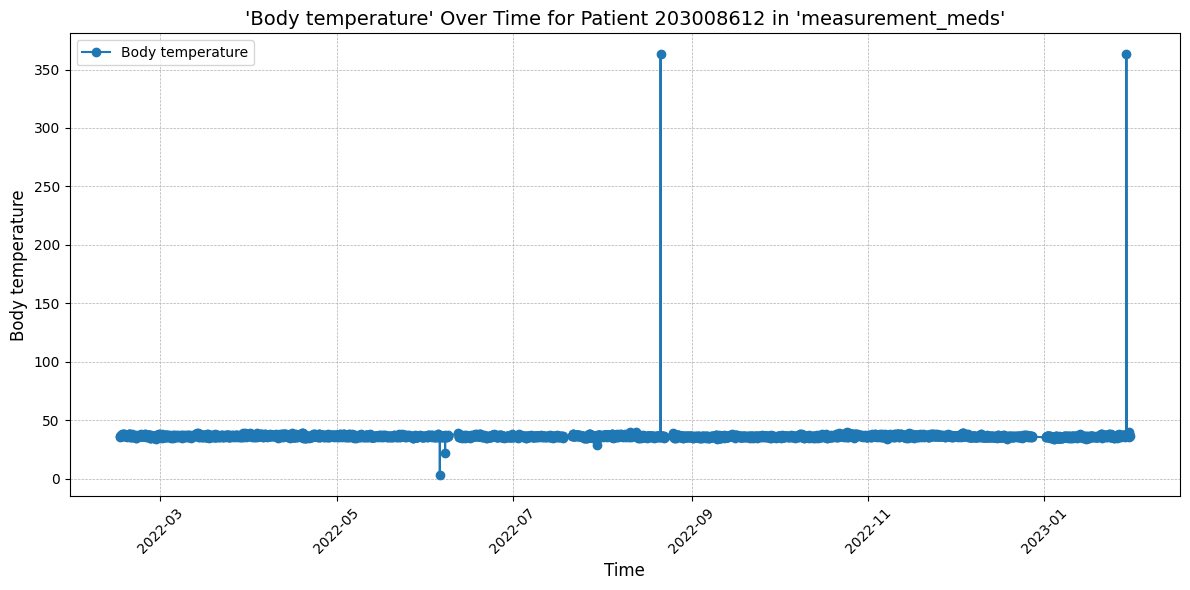

In [77]:
# Select the table, patient ID, and variables of interest
table_name = "measurement_meds"
selected_table = tables_train['train'][table_name]  # Replace with the appropriate table from tables_train or tables_test
example_patient_id = 203008612

variables_to_analyze = ['Respiratory rate', 'Heart rate', 'Measurement of oxygen saturation at periphery',
                        'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure','Body temperature']  # Replace with actual variable names
time_column = 'measurement_datetime'  # Replace with the actual time column name

# Analyze time series for the selected table
analyze_patient_time_series_single_table(selected_table, table_name, example_patient_id, time_column, variables_to_analyze)


Analyzing time series for patient 203008612 in table 'SepsisLabel'...


C:\Users\Ruhaan\AppData\Local\Temp\ipykernel_7780\1190839170.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data[time_column] = pd.to_datetime(patient_data[time_column])


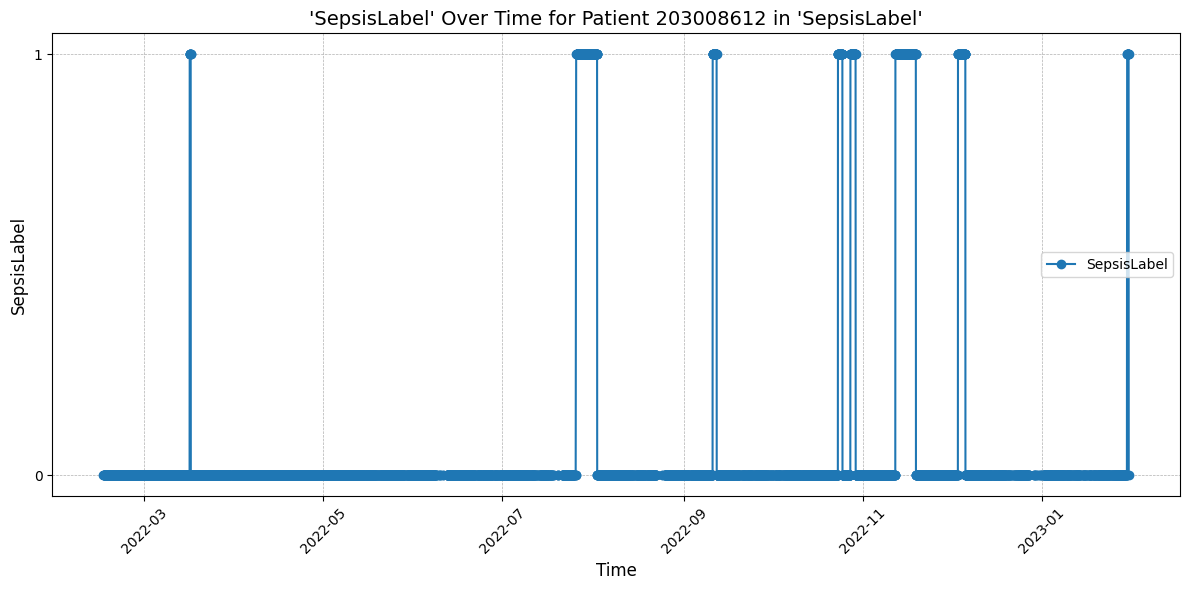

In [79]:
# Select the table, patient ID, and variables of interest
table_name = "SepsisLabel"
selected_table = tables_train['train'][table_name]  # Replace with the appropriate table from tables_train or tables_test
example_patient_id = 203008612

variables_to_analyze = ['SepsisLabel'] #Replace with actual variable names
time_column = 'measurement_datetime'  # Replace with the actual time column name

# Analyze time series for the selected table
analyze_patient_time_series_single_table(selected_table, table_name, example_patient_id, time_column, variables_to_analyze)